<p style="padding: 10px;
          font-size:50px;
          font-weight: bolder;
          color: rgba(124, 203, 234, 0.75)">
    Task 3
</p>

- Author: Anatoly Medvedev
- Group: J4322c

<a name="000" style="color: black">
    <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
        Table of Сontents
    </p>
</a>

<div style="padding: 20px;
            margin-top: 20px;
            color: black;
            background: rgba(124,203,234,0.25)">
    <ol>
        <li><a href="#001">Dataset</a></li>
        <li><a href="#002">Model</a></li>
        <li><a href="#003">Model Training</a></li>
        <li><a href="#004">Model Validation</a></li>
        <li><a href="#005">Conclusion</a></li>
    </ol>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
warnings.filterwarnings(action="ignore")
sns.set_style("whitegrid")
%matplotlib inline

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="001" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Dataset
        </p>
    </a>
</blockquote>

Select one of the datasets with low-resolution images (for example, you can use FashionMNIST, CIFAR-10 or CIFAR-100 datasets).

In the course of the laboratory work, dataset `FashionMNIST` from `torchvision.datasets` library was used.

In [2]:
epochs = 35
batch_size = 64
lr = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    root="input",
    train=True,
    download=False,
    transform=transform
)

val_dataset = torchvision.datasets.FashionMNIST(
    root="input",
    train=False,
    download=False,
    transform=transform
)

In [5]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="002" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Model
        </p>
    </a>
</blockquote>

In the laboratory work, PyTorch implementation of ConditionalVAE was developed for generating images.

Also, an object classifier was added to the model architecture to calculate classification losses.

In [6]:
class ConditionalVAE(nn.Module):
    def __init__(self, n_features=64, n_classes=10):
        super(ConditionalVAE, self).__init__()
        
        self.features = n_features
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.features*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=784)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=784, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=n_classes)
        )
        
        self.sigmoid = nn.Sigmoid()
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        
        return sample
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 2, self.features)
        
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        z = self.reparameterize(mu, log_var)
        
        x = self.decoder(z)
        reconstruction = self.sigmoid(x)
        
        logits = self.classifier(reconstruction)
        probs = self.sigmoid(logits)
        
        return reconstruction, probs, mu, log_var

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="003" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Model Training
        </p>
    </a>
</blockquote>

Train conditional variational autoencoder to generate new images of the classes presented in your labeled data. You should update all the necessary hyperparameters in `ConditionalVAE` example in order to fit the characteristics of your dataset (image dimensions, number of images, batch size etc.)

In [7]:
model = ConditionalVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction="sum")
softmax = nn.Softmax(dim=1)
class_criterion = nn.L1Loss()

In [8]:
def loss(bce_loss, mu, logvar):
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
def fit(model, dataloader):
    class_loss = 0.0
    running_loss = 0.0
    
    model.train()
    for _, batch in tqdm(enumerate(dataloader), total=int(len(train_dataset)/dataloader.batch_size)+1):
        image, target = batch
        image = image.to(device).view(image.size(0), -1)
        
        optimizer.zero_grad()
        
        reconstruction, probs, mu, logvar = model(image)
        
        probs = softmax(probs.cpu().detach()).argmax(dim=1).float()
        current_class_loss = class_criterion(probs, target.float())
        class_loss += current_class_loss.item()
        
        bce_loss = criterion(reconstruction, image)
        current_loss = loss(bce_loss, mu, logvar)
        running_loss += current_loss.item()
        
        final_loss = 0.5 * (current_class_loss + current_loss)
        
        final_loss.backward()
        optimizer.step()
    
    train_loss = running_loss / len(dataloader.dataset)
    train_class_loss = class_loss / len(dataloader.dataset)
    
    return train_loss, train_class_loss

In [10]:
def validate(model, dataloader):
    class_loss = 0.0
    running_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(dataloader), total=int(len(val_dataset)/dataloader.batch_size)+1):
            image, target = batch
            image = image.to(device).view(image.size(0), -1)
            
            reconstruction, probs, mu, logvar = model(image)
            
            probs = softmax(probs.cpu().detach()).argmax(dim=1).float()
            current_class_loss = class_criterion(probs, target.float())
            class_loss += current_class_loss.item()
            
            bce_loss = criterion(reconstruction, image)
            current_loss = loss(bce_loss, mu, logvar)
            running_loss += current_loss.cpu().detach().item()
            
            if idx == int(len(val_dataset)/dataloader.batch_size) - 1:
                both = torch.cat((image.view(batch_size, 1, 28, 28)[:10],
                                  reconstruction.view(batch_size, 1, 28, 28)[:10]))
                save_image(both.cpu(), f"output/epoch_{epoch+1}.png", nrow=10)
    
    val_loss = running_loss / len(dataloader.dataset)
    val_class_loss = class_loss / len(dataloader.dataset)
    
    return val_loss, val_class_loss

In [11]:
train_loss = []
train_class_loss = []
val_loss = []
val_class_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_epoch_loss, train_epoch_class_loss = fit(model, train_loader)
    val_epoch_loss, val_epoch_class_loss = validate(model, val_loader)
    
    train_loss.append(train_epoch_loss)
    train_class_loss.append(train_epoch_class_loss)
    val_loss.append(val_epoch_loss)
    val_class_loss.append(val_epoch_class_loss)
    
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Test Loss: {val_epoch_loss:.4f}")
    
    print(f"Train Classification Loss: {train_epoch_class_loss:.4f}")
    print(f"Test Classification Loss: {val_epoch_class_loss:.4f}\n")

Epoch 1 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 76.71it/s]


Train Loss: 328.2143
Test Loss: 293.7831
Train Classification Loss: 0.0495
Test Classification Loss: 0.0512

Epoch 2 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 75.95it/s]


Train Loss: 283.2708
Test Loss: 277.5862
Train Classification Loss: 0.0508
Test Classification Loss: 0.0505

Epoch 3 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 76.96it/s]


Train Loss: 271.7762
Test Loss: 270.0164
Train Classification Loss: 0.0511
Test Classification Loss: 0.0516

Epoch 4 of 35


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.13it/s]


Train Loss: 266.0716
Test Loss: 265.3776
Train Classification Loss: 0.0513
Test Classification Loss: 0.0518

Epoch 5 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 78.12it/s]


Train Loss: 261.9725
Test Loss: 261.6762
Train Classification Loss: 0.0514
Test Classification Loss: 0.0520

Epoch 6 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.10it/s]


Train Loss: 258.4815
Test Loss: 258.6556
Train Classification Loss: 0.0517
Test Classification Loss: 0.0521

Epoch 7 of 35


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 103.81it/s]


Train Loss: 255.4773
Test Loss: 255.9719
Train Classification Loss: 0.0519
Test Classification Loss: 0.0525

Epoch 8 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.49it/s]


Train Loss: 252.9035
Test Loss: 253.2818
Train Classification Loss: 0.0521
Test Classification Loss: 0.0523

Epoch 9 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.13it/s]


Train Loss: 250.7669
Test Loss: 251.4931
Train Classification Loss: 0.0522
Test Classification Loss: 0.0531

Epoch 10 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.64it/s]


Train Loss: 249.1422
Test Loss: 250.6537
Train Classification Loss: 0.0524
Test Classification Loss: 0.0524

Epoch 11 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 78.78it/s]


Train Loss: 247.8765
Test Loss: 249.1199
Train Classification Loss: 0.0524
Test Classification Loss: 0.0522

Epoch 12 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 77.72it/s]


Train Loss: 246.9503
Test Loss: 248.1066
Train Classification Loss: 0.0524
Test Classification Loss: 0.0529

Epoch 13 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 78.77it/s]


Train Loss: 246.1722
Test Loss: 247.4374
Train Classification Loss: 0.0525
Test Classification Loss: 0.0523

Epoch 14 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.88it/s]


Train Loss: 245.5465
Test Loss: 246.7987
Train Classification Loss: 0.0525
Test Classification Loss: 0.0532

Epoch 15 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 78.37it/s]


Train Loss: 244.9144
Test Loss: 246.3936
Train Classification Loss: 0.0525
Test Classification Loss: 0.0527

Epoch 16 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.34it/s]


Train Loss: 244.4302
Test Loss: 246.0214
Train Classification Loss: 0.0524
Test Classification Loss: 0.0531

Epoch 17 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.38it/s]


Train Loss: 244.0016
Test Loss: 245.4647
Train Classification Loss: 0.0524
Test Classification Loss: 0.0528

Epoch 18 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.97it/s]


Train Loss: 243.5826
Test Loss: 245.1144
Train Classification Loss: 0.0524
Test Classification Loss: 0.0528

Epoch 19 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 78.26it/s]


Train Loss: 243.2442
Test Loss: 244.6823
Train Classification Loss: 0.0525
Test Classification Loss: 0.0531

Epoch 20 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 78.97it/s]


Train Loss: 242.8434
Test Loss: 244.5268
Train Classification Loss: 0.0524
Test Classification Loss: 0.0527

Epoch 21 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.88it/s]


Train Loss: 242.5228
Test Loss: 244.0923
Train Classification Loss: 0.0524
Test Classification Loss: 0.0524

Epoch 22 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.11it/s]


Train Loss: 242.2509
Test Loss: 243.9037
Train Classification Loss: 0.0524
Test Classification Loss: 0.0531

Epoch 23 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.44it/s]


Train Loss: 241.9960
Test Loss: 243.8705
Train Classification Loss: 0.0524
Test Classification Loss: 0.0529

Epoch 24 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 78.45it/s]


Train Loss: 241.7258
Test Loss: 243.5731
Train Classification Loss: 0.0523
Test Classification Loss: 0.0522

Epoch 25 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.46it/s]


Train Loss: 241.5131
Test Loss: 243.1675
Train Classification Loss: 0.0524
Test Classification Loss: 0.0529

Epoch 26 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.30it/s]


Train Loss: 241.2723
Test Loss: 242.8941
Train Classification Loss: 0.0524
Test Classification Loss: 0.0527

Epoch 27 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.36it/s]


Train Loss: 241.0857
Test Loss: 242.8850
Train Classification Loss: 0.0523
Test Classification Loss: 0.0522

Epoch 28 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.75it/s]


Train Loss: 240.8791
Test Loss: 242.6146
Train Classification Loss: 0.0524
Test Classification Loss: 0.0530

Epoch 29 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.90it/s]


Train Loss: 240.7081
Test Loss: 242.5617
Train Classification Loss: 0.0523
Test Classification Loss: 0.0526

Epoch 30 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.42it/s]


Train Loss: 240.5479
Test Loss: 242.6075
Train Classification Loss: 0.0524
Test Classification Loss: 0.0523

Epoch 31 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.41it/s]


Train Loss: 240.3601
Test Loss: 242.4444
Train Classification Loss: 0.0524
Test Classification Loss: 0.0528

Epoch 32 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.40it/s]


Train Loss: 240.1900
Test Loss: 242.1009
Train Classification Loss: 0.0523
Test Classification Loss: 0.0527

Epoch 33 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.90it/s]


Train Loss: 240.0565
Test Loss: 241.9411
Train Classification Loss: 0.0523
Test Classification Loss: 0.0529

Epoch 34 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.29it/s]


Train Loss: 239.9068
Test Loss: 241.8163
Train Classification Loss: 0.0523
Test Classification Loss: 0.0523

Epoch 35 of 35


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.62it/s]

Train Loss: 239.7760
Test Loss: 241.6368
Train Classification Loss: 0.0523
Test Classification Loss: 0.0530



<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="004" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Model Validation
        </p>
    </a>
</blockquote>

Plot the learning curves to ensure that the algorithm has been converged and there is no overfitting.

In [12]:
def plot(train_data, val_data, title):
    figure = plt.figure(figsize=(10, 5))
    
    plt.plot(train_data, linewidth=2, color="b")
    plt.plot(val_data, linewidth=2, color="r")

    plt.ylabel("Value")
    plt.xlabel("Epoch")
    plt.title(title)
    plt.show()

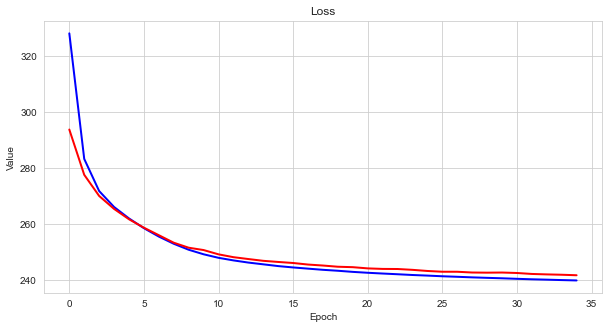

In [14]:
plot(train_loss, val_loss, "Loss")

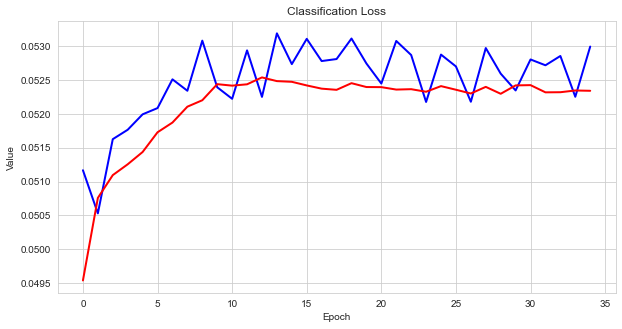

In [13]:
plot(val_class_loss, train_class_loss, "Classification Loss")

Select and plot separately N images for every class in your data.

In [54]:
show_loader = DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True
)

Label 0:


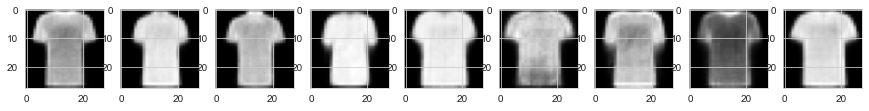

Label 1:


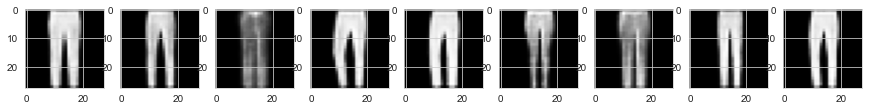

Label 2:


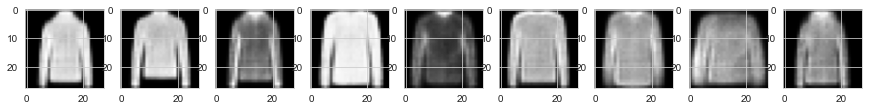

Label 3:


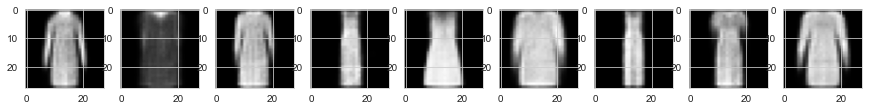

Label 4:


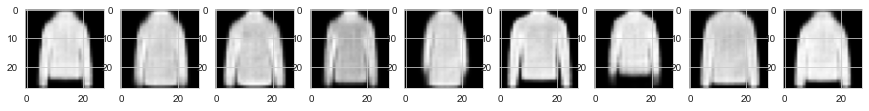

Label 5:


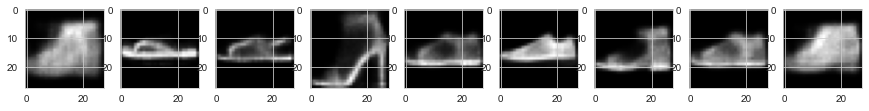

Label 6:


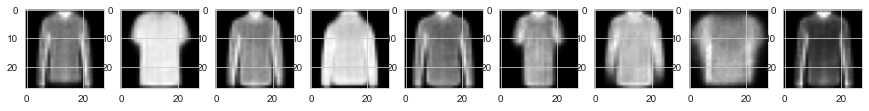

Label 7:


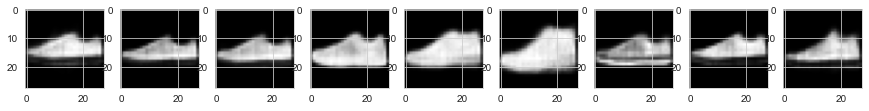

Label 8:


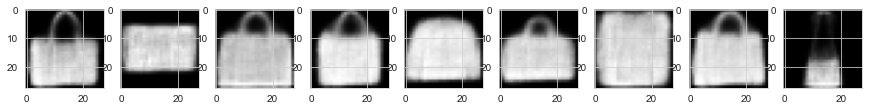

Label 9:


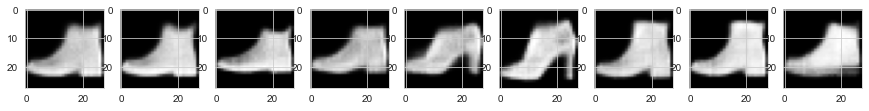

In [55]:
model.eval()
with torch.no_grad():
    while True:
        for label in range(10):
            print(f"Label {label}:")
            fig, ax = plt.subplots(1, 9, figsize=(15, 15))
            count = 0
            for batch in show_loader:
                image, target = batch
                if target == label:
                    image = image.to(device).view(image.size(0), -1)
                    reconstruction, _, _, _ = model(image)
                    reconstruction = reconstruction.cpu().detach().view(1, 28, 28).numpy()
                    reconstruction = np.transpose(reconstruction, (1, 2, 0))
                    ax[count].imshow(reconstruction, "gray")
                    count += 1
                if count == 9:
                    plt.show()
                    break
        break

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="004" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Conclusion
        </p>
    </a>
</blockquote>

In the course of the laboratory work, autoencoder was developed for generating images from labeled data. The PyTorch implementation of the autoencoder was used to train the model using GPU.

Models based on fully connected layers are not robust, as the training results show. Therefore, in the task of generating images, it is worth trying to apply architectures based on convolution, parallel convolution, attention mechanisms, etc.

Nevertheless, even these architectures with fine tuning of hyperparameters are able to show good results on 1-channel images with low quality, as it is demonstrated in the work.